# Plan for the seminar
* Warm up: decision trees - their strengths and limitations
* Moving slowly to real world - bagging ensembles
* Heavy duty maching learning - gradient boosting machines

# Decision Trees
![Decision tree joke](https://camo.githubusercontent.com/08b9d1f7280425a77ddf445fb40dc1e0827ea44a/68747470733a2f2f7062732e7477696d672e636f6d2f6d656469612f4231336e3256564349414130684a532e6a7067)

(Based on our [previos course](https://github.com/yandexdataschool/MLatImperial2019-private/blob/master/04_lab/lab4_trees_ensambling_stacking.ipynb))

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Generating a toy dataset with 2 features for binary classification:

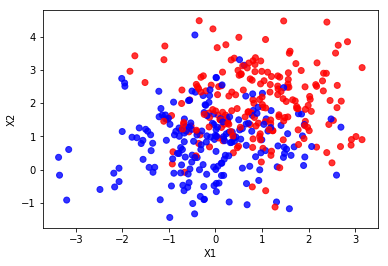

In [2]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
                          centers=[[0., 1.], [1., 2.]],
                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

## Enter Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Key parameters:
* `max_depth` – a limit on tree depth (default – no limit)
* `min_samples_split` – there should be at least this many samples to split further (default – 2)
* `min_samples_leaf` – there should be at least this many samples on one side of a split to consider it valid (default – 1).
* `criterion` – the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.


In [0]:
from sklearn.metrics import accuracy_score
import matplotlib
def plot_decision_surface(clf,
                          X: np.ndarray,
                          y: np.ndarray,
                          grid_step: float=0.02,
                          cmap='bwr',
                          alpha:float=0.6,
                          axes=None
        ):
    """
    Plot the decision surface of a classifier, visualize selected points
    Args:
      clf: a fitted model, must support predict method
      X[n_examples, n_features]: points where to evaluate the classifier
      y[n_examples]: true labels
      grid_step: decision surface plottting grid
      alpha: opacity of the decision surface
      axes(matplotlib.axes._subplots.AxesSubplot): axes where plot, if None, a new figure is created
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    if axes is None:
      _, axes = plt.subplots()
    axes.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    axes.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    axes.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    axes.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    axes.legend(loc='best')

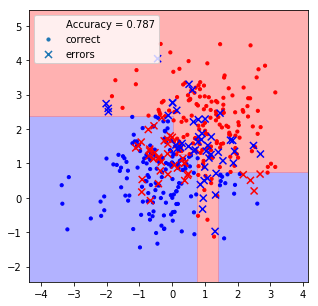

In [5]:
clf = DecisionTreeClassifier(min_samples_leaf=15).fit(X_toy, y_toy)
fig, ax = plt.subplots(figsize=(5, 5))
plot_decision_surface(clf, X_toy, y_toy, axes=ax)

Let's load the multiclassification toy data:

In [6]:
! wget https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz

--2019-06-30 10:06:57--  https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/mlhep2018/master/day1-Mon/data.npz [following]
--2019-06-30 10:06:57--  https://raw.githubusercontent.com/yandexdataschool/mlhep2018/master/day1-Mon/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz.4’

data.npz.4          100%[===================>] 105.93K  --.-KB/s    in 0.03s   

2019-06-30 10:06:57 (3.37 MB/s) - ‘data.npz.4’ saved [108474/108474]



In [0]:
muticlass_toy_data = np.load("data.npz")
X_toy_multiclass_train, X_toy_multiclass_test, \
  y_toy_multiclass_train, y_toy_multiclass_test = \
    train_test_split(muticlass_toy_data["X"], muticlass_toy_data["y"],
                     test_size=0.5, random_state=1337)

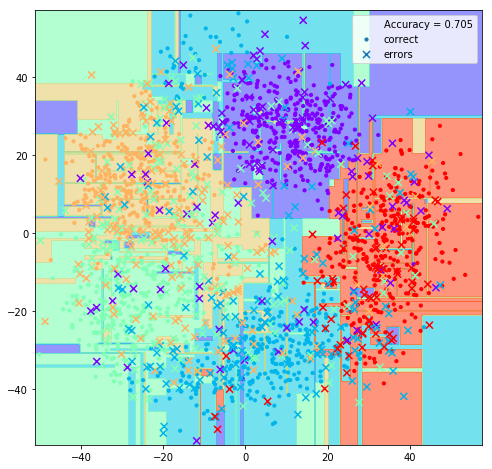

In [8]:
clf = DecisionTreeClassifier()
clf.fit(X_toy_multiclass_train, y_toy_multiclass_train)
fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(clf, X_toy_multiclass_test, y_toy_multiclass_test, cmap='rainbow', grid_step=0.2, axes=ax);

### Task 2 (difficulty: moderate)
We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy.

    Accuracy >= 0.72 - not bad for a start
    Accuracy >= 0.75 - better, but not enough
    Accuracy >= 0.77 - pretty good
    Accuracy >= 0.78 - great! (probably the best result for a single tree)

Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

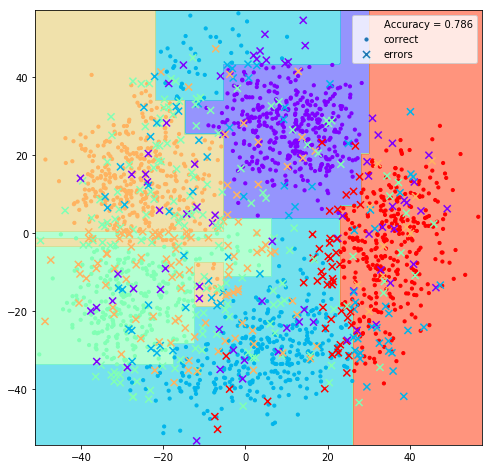

In [9]:
#### SOLUTION!!! ####

clf = DecisionTreeClassifier(min_samples_leaf=15, criterion='entropy')
clf.fit(X_toy_multiclass_train, y_toy_multiclass_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(clf, X_toy_multiclass_test, y_toy_multiclass_test, cmap='rainbow', grid_step=0.2, axes=ax);

### Task 1 (difficulty: easy)
Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the `max_depth` parameter. Try out the following values: ``[1, 2, 3, 5, 10]``. Make decision boundary plots for both train and test datasets (separately).

In [0]:
X_toy_train, X_toy_test, y_toy_train, y_toy_test = \
    train_test_split(X_toy, y_toy, test_size=0.25, random_state=42)

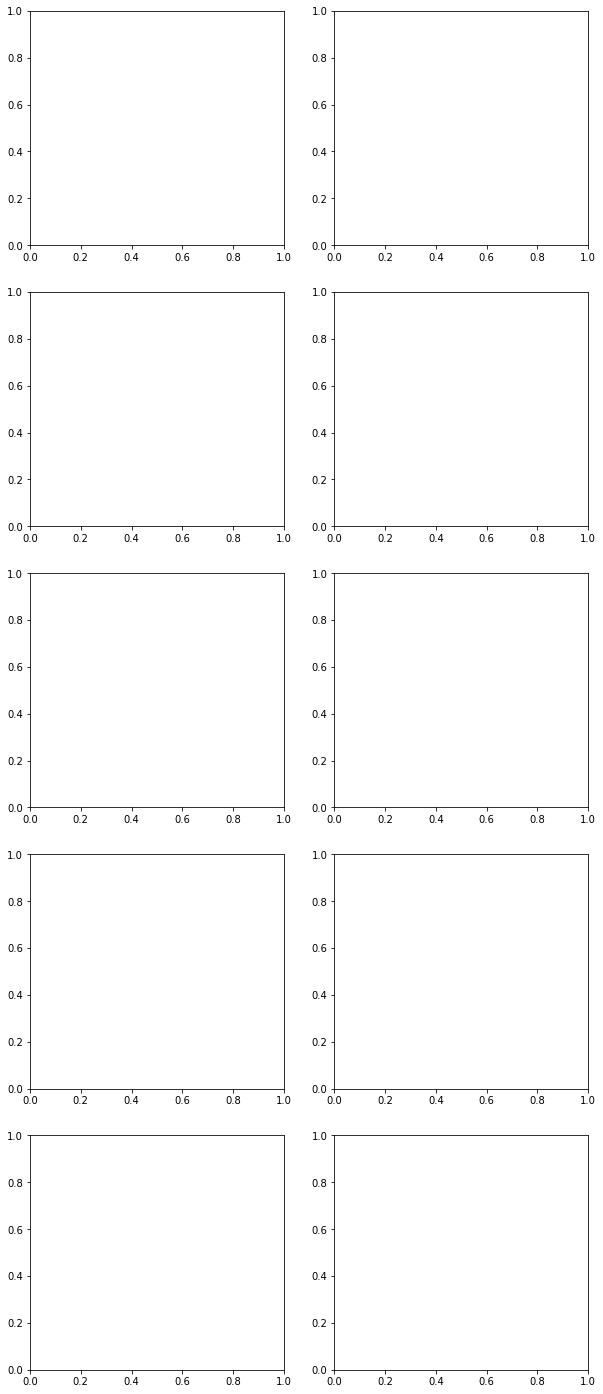

In [11]:
depth_values = [1, 2, 3, 5, 10]

fig, axes_matrix = plt.subplots(nrows=len(depth_values), ncols=2,
                                figsize=(2*5, 5*len(depth_values)))
for depth, (axes_train, axes_test) in zip(depth_values, axes_matrix):
  # <Your code goes here>
  # The boilerplate code is the elegant way to get a grid of plots in matplotlib
  # All you need is to fit a decision tree and call plot_decision_surface
  # axes_train and axes_test for train and test plots correspondingly
  pass

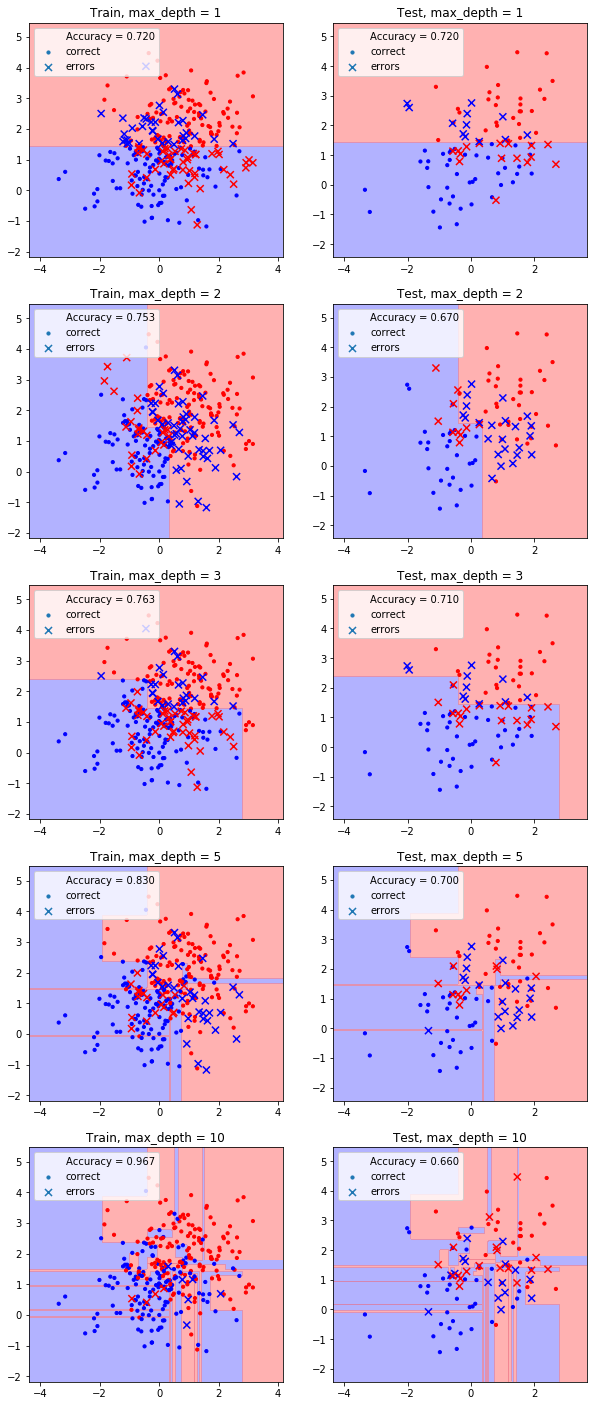

In [12]:
depth_values = [1, 2, 3, 5, 10]

fig, axes_matrix = plt.subplots(nrows=len(depth_values), ncols=2,
                                figsize=(2*5, 5*len(depth_values)))
for depth, (axes_train, axes_test) in zip(depth_values, axes_matrix):
  # Define and fit the classifier
  clf = DecisionTreeClassifier(max_depth=depth)
  clf.fit(X_toy_train, y_toy_train)
  
  # Make decision plot with train data
  plot_decision_surface(clf, X_toy_train, y_toy_train, axes=axes_train)
  axes_train.set_title("Train, max_depth = {}".format(depth))
  
  # Make decision plot with test data
  plot_decision_surface(clf, X_toy_test, y_toy_test, axes=axes_test)
  axes_test.set_title("Test, max_depth = {}".format(depth))

## Decision trees conclusion
Key advantages:
* Interpretable results
* Not sensitive to data scaling
* Natural support for missing values and categorial data

Key disadvanatages:
* (comparatively) poor quality of the result
* Unstable training - small variations in the data might result in a completely different tree being generated



# Ensembles warm up: Random Forest
Random forest fits multiple trees on random subsets of examples and features. They are better than raw decision trees almost in every respect - with the exception of interpretability.

Compared to boosting, the advantages are:
* Harder to overfit. Overfitting will not be made worse by adding more trees. Question to you: why?
* Very easy to implement parallel training. If you ever have to do it by yourself for whatever reason...

Compared to boosting, the disadvantage is worse quality.

Please take your time to enjoy the beatiful smooth decision surface:



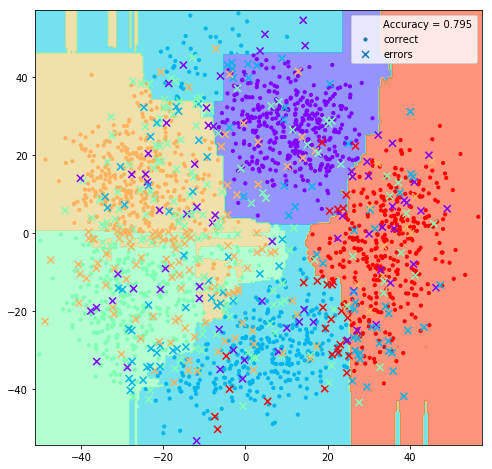

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Note the n_jobs parameter: it defines the number of parallel training processes
# -1 means to use all available
random_forest = RandomForestClassifier(n_estimators=100,
                               min_samples_leaf=5,
                               n_jobs=-1)

random_forest.fit(X_toy_multiclass_train, y_toy_multiclass_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(random_forest,
                      X_toy_multiclass_test,
                      y_toy_multiclass_test,
                      cmap='rainbow', grid_step=0.4, axes=ax)

# Something you'll actually use: Gradient Boosting machines
From user point of view the competing toolkits are largely the same. Think BMW vs. Mercedes or Tensorflow 2 vs pytorch. In each there is clever engeneering, smart algorithm enchantments and ingenious heuristic tricks, but for common tasks the performance difference is different from paper to paper and is small for practical purposes.

They all support multithreading, have commited developer communities, documentation, and, subjectively, are great pieces of software. As of 2019 in chronological order:

### XGBoost
* Is the oldest and the most known
* Multi-node Multi-GPU distributed training

#### Notable technical details [[paper](https://arxiv.org/pdf/1603.02754.pdf)]:
* Can use [DART: Dropouts meet Multiple Additive Regression Trees](http://proceedings.mlr.press/v38/korlakaivinayak15.pdf)
* Can use exact, approximate and histogram-based split search

### Light GBM
* Fast training
* GPU training
* [Distributed training](https://github.com/microsoft/LightGBM/blob/master/docs/Parallel-Learning-Guide.rst)

#### Notable [technical details](https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst) [[paper](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)]
* Gradient-based One-Side Sampling (GOSS)
* Exclusive Feature Bundling(EFB). 
* LightGBM uses histogram-based algorithms, which bucket continuous feature (attribute) values into discrete bins. 
* Leaf-wise (Best-first) Tree Growth

### Catboost
* Built-in handling of categorial features
* Single-node Multi-GPU training
* Is fast to run the prediction (we use in LHCb trigger)
* [Fancy Jupyter training visualisation](https://catboost.ai/docs/features/visualization.html) (sadly, doesn't work in colab)

#### Notable technical details [[paper](https://arxiv.org/pdf/1706.09516.pdf)]:
* Uses oblivious trees. They are less flexible than the ordinary trees, but are a lot faster to evaluate

![oblivious trees](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-1/oblivious_tree.webp)

* Ordered boosting: for calculating the residual on an example, uses a model trained without it
* Uses histogram-based split selection

# Primer on Gradient boosting
Install a GPU-enabled version of lightgbm. Might take a couple of minutes.

In [14]:
! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
  Using cached https://files.pythonhosted.org/packages/c9/ce/3aff55e25e282383c19c5a5fb7387fd400e64b1a1036671aefa63ceeaaf4/lightgbm-2.2.3.tar.gz
Skipping bdist_wheel for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Running setup.py install for lightgbm ... done


Install catboost

In [15]:
! pip install catboost

Get the Higgs dataset (again, takes 2-5 minutes)

In [16]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2019-06-30 10:08:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz.2’

HIGGS.csv.gz.2      100%[===================>]   2.62G  58.3MB/s    in 40s     

2019-06-30 10:09:23 (67.3 MB/s) - ‘HIGGS.csv.gz.2’ saved [2816407858/2816407858]



In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [0]:
data = np.genfromtxt("HIGGS.csv.gz", 
                     delimiter=",", dtype=np.float32, max_rows=200000)
X, y = data[:, 1:], data[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [0]:
import catboost
import xgboost
import lightgbm

GPU models:

In [0]:
models_gpu = {
    "catboost": catboost.CatBoostClassifier(verbose=False, task_type='GPU'),
    "xgboost": xgboost.XGBClassifier(tree_method="gpu_hist"),
    "lightgbm": lightgbm.LGBMClassifier(device_type="gpu")
}

CPU models:

In [0]:
models_cpu = {
    "catboost": catboost.CatBoostClassifier(verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(tree_method="hist", thread_count=-1),
    "lightgbm": lightgbm.LGBMClassifier(thread_count=-1)
}

Will show "GPU memory usage is close to the limit" - this is expected, catboost allocates all available GPU memory

In [0]:
import time
def evaluate_models(models_dict):
  for model_name, model in models_dict.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    print("{}; train time {:.3f} s; ROC AUC = {:.3f}".format(
          model_name,
          end - start,
          roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

In [23]:
evaluate_models(models_gpu)

catboost; train time 10.314 s; ROC AUC = 0.812
xgboost; train time 0.997 s; ROC AUC = 0.788
lightgbm; train time 2.781 s; ROC AUC = 0.806


In [24]:
evaluate_models(models_cpu)

catboost; train time 73.382 s; ROC AUC = 0.812
xgboost; train time 2.312 s; ROC AUC = 0.788
lightgbm; train time 3.366 s; ROC AUC = 0.806




## Parameter tuning
* Most important is learning rate and number of iterations

N. B.
We don't have time to thoroughly discuss all options of all packages - if you are interested in parameter tuning, please read the documentation of the library of choice.

## Task 3.1 (difficulty: semi-real life)
The above train time comparison is not fair. We just ran training with default parameters - it is always possible that, if we take more iterations for some models and less for others, both timing and discrimination performances would arrange themselves differently. Your task is to do a fair comparison.

a. As a baseline, plot the ROC AUC as function of training time for different libraries, by varying just the number of iterations
b. Write a function that selects the optimal learning rate. `staged_predict` is your 

# Ensembling - recap
* Combining several models in a semi-clever way usually results in better quality
* The most common ways are stacking, bagging and boosting
* Stacking is how deep learning works - by using the output of one model  as features to another.
* Stacking is a common thing in competititive data science, where it allows to get that 0.0001%. A coommon quick and dirty technique of averagin predictions of different models can be viewed as stacking with a linear model.
* Boosted decision trees have quality competitive with deep learning on tabular data. In general (please don't quote me on this), there is a trend that the smaller the datasets, the better will gradient boosting perform, compared to a fully-connected MLP. Tabular - i. e. without assumptions of structure in featueres, such as when they pixels in an image. E. g. [Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS) is tabular, but ImageNet is not.